---

Dateiname: Warenkorbanalyse.ipynb  
Autor: Beatrice Steiner  
E-Mail: [ds201017@fhstp.ac.at](mailto:ds201017@fhstp.ac.at)  
Artikel: [Kaufrausch durch Data Science?](https://datanauts.at/blog/blog-eintrag-1)  
Datum: 2021-07-05


# Kaufrausch durch Data Science?

*Warenkorbanalysen versuchen seit längerem ein einmaliges Einkaufserlebnis abgestimmt auf die Kund/inn/en im E-Commerce zu bieten. Dass durch Mathematik und Statistik relevante Informationen für die Händler/innen erschaffen werden können, ist meist aber nur als Privileg für große Portale bekannt. Das übergeordnete Ziel der Warenkorbanalyse ist es, verdeckte Zusammenhänge von historischen Käufen zu finden und damit die Gewinne und Wettbewerbsfähigkeit der Unternehmen zu steigern. Nachfolgend wird mittels der meist sowieso gespeicherten Daten, der Vorgang der Warenkorbanalysen beim on- und offline Handel beschrieben und eine Analyse mit Python erstellt.*

---

Als Basisdaten für eine Warenkorbanalyse werden die Transaktionsdaten eines Kaufes benötigt. Damit sind also die einzelnen Produkte gemeint, die Unterteilung erfolgt dabei pro Kauf. Damit sollen dann Assoziationen geschaffen werden. Wenn beispielsweise jemand eine Zahnbürste im Warenkorb hat, wird diese Person wahrscheinlich auch Zahnpasta hinzufügen. Dabei liegt der Fokus also auf ergänzende Produkte zum Ausgangsprodukt. Für Data Mining im Bereich der Warenkorbanalyse wird oft auf dem Apriori-Algorithmus zurückgegriffen. Für den Apriori-Algorithmus gibt es drei relevante Kennzahlen: Support, Konfidenz und Lift. Zunächst eine Erklärung dieser drei Werte.

Der Support gibt den prozentuellen Wert an, wie oft ein Produkt auf Basis aller Käufe gekauft wird. Da man in diesem Anwendungsfall aber von zusammenhängenden Käufen ausgeht, möchte man in diesem Fall die Wahrscheinlichkeit, dass Zahnbürste und Zahnpasta zusammen gekauft werden, bestimmen. Je höher dieser Wert ist, desto öfter werden diese Produkte zusammen gekauft.

$Support(A \to  B)=\frac{Haeufigkeit(Produkt A und Produkt B zusammen)}{Anzahl(Transaktionen)}$

Die Konfidenz gibt die Kaufwahrscheinlichkeit des zweiten Produktes an, wenn das erste Produkt gegeben ist. In diesem Fall also mit welcher Wahrscheinlichkeit beim Kauf einer Zahnbürste auch eine Zahnpasta gekauft wird. Je höher die Wahrscheinlichkeit ist, desto eher werden die beiden Produkte zusammen erworben. 

$Konfidenz(A \to  B)=\frac{Haeufigkeit(Produkt A und Produkt B zusammen)}{Haeufigkeit(Produkt A)}$

Der Lift gibt den Auswirkungsgrad des Kaufes vom Folgeprodukt zum Basisprodukt an. Ein Wert, der größer als 1 (> 100%) ist, gibt an, dass ein positiver Zusammenhang besteht. Erhält man einen Lift von 1,5, bedeutet das, dass der Kauf vom Basisprodukt die Wahrscheinlichkeit des Kaufes des Folgeproduktes um 50% erhöht. Bei Werten unter 1 (< 100%) besagt dies z.B. bei 0,5, dass der Kauf des Folgeproduktes um 50% weniger wahrscheinlich ist. 

$Lift(A \to  B)=\frac{Support(A \to  B)}{Support(A)*Support(B)}$

## Praktisches Beispiel

Als Basis werden die Daten einer Bäckerei herangezogen. Diese sind unter https://www.kaggle.com/sulmansarwar/transactions-from-a-bakery aufrufbar. Das Datenset besteht aus vier Spalten. Diese sind das Datum, die Uhrzeit der Transaktion, die Transaktion (ID) und das Produkt. Mittels dieses Datensatzes werden nun in Python Abhängigkeiten der Produkte ermittelt. 

Folgende Bibliotheken sind dafür zu importieren. 

In [1]:
# Import der Pakete für Warenkorbanalyse
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules, apriori

Zuerst muss dafür das Datenset importiert werden. Dafür wird die Python-Bibliothek Pandas verwendet. Außerdem werden leere Produkte verworfen, damit wird die Datenqualität gesteigert. 

In [2]:
df = pd.read_csv('./BreadBasket_DMS.csv')
df.drop(df[df['Item']=='NONE'].index, inplace=True)

Nun folgt eine Schleife, welche alle Produkte einer Transaktion zusammenfügt. Pro Transaktion kennt man anschließend also alle gekauften Waren. 

In [3]:
#Liste der Produkte pro Transaktion
transaction_list = []
# FOR-Schleife zum Erstellen einer Liste der eindeutigen Transaktionen im Data-Set:
for i in df['Transaction'].unique():
    tlist = list(set(df[df['Transaction']==i]['Item']))
    if len(tlist)>0:
        transaction_list.append(tlist)

Anschließend folgt noch eine Transformation der Daten, sodass alle Produkte encodiert sind und damit mit true und false betitelt werden können, da die darauffolgende apriori-Funktion nur mit true/false bzw. 0/1 arbeiten kann. 

In [4]:
#Encoding der Transaktionen
te = TransactionEncoder()
te_ary = te.fit(transaction_list).transform(transaction_list)
df_ary = pd.DataFrame(te_ary, columns=te.columns_)

Danach kann dieser DataFrame bereits an die apriori-Funktion übergeben werden. Der minimale Supportwert wird auf 0,01 festgelegt. Die Elemente werden nochmals gefiltert, um nur Elemente mit einem Lift-Wert von über 1 im DataFrame zu haben. 

In [5]:
#apriori-Funktion anwenden
frequent_itemsets = apriori(df_ary, min_support=0.01, use_colnames=True)
#Elemente mit einem Lift-Wert von über 1 in DataFrame
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.0)

Zuletzt werden noch die benötigten Spalten gefiltert, um anschließend die Assoziationen nach dem Lift-Wert absteigend zu sortieren und auszugeben. „Antecedents“ sind als Basisprodukte zu betrachten und die “Consequents” als Folgeprodukte. 

In [6]:
#Nur die 'support', 'confidence', 'lift' Spalten anzeigen
result = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
#nach 'lift' absteigend sortieren
result = result.sort_values('lift', ascending=False)

Die vier größten Zusammenhänge sind nachfolgend aufgelistet: 

In [7]:
result.head(4)

,antecedents,consequents,support,confidence,lift
40,(Cake),"(Tea, Coffee)",0.010037,0.096643,1.937977
39,"(Tea, Coffee)",(Cake),0.010037,0.201271,1.937977
8,(Cake),(Hot chocolate),0.011410,0.109868,1.883874
9,(Hot chocolate),(Cake),0.011410,0.195652,1.883874


Danach kann man die Assoziationen auch gut mit einer Heat-Map darstellen. 

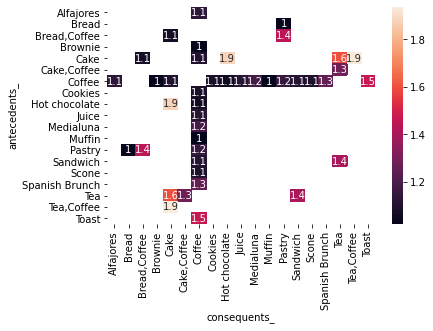

In [8]:
#Formatieren der Antecedents und Consequents
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))
# Transformieren des DataFrames der 'rules' in Matrix mit 'lift'-Wert
pivot = rules.pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')
#Heatmap mit Assoziationen erzeugen
sns.heatmap(pivot, annot = True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

Je heller auf dieser Heat-Map ein Feld ist, desto stärker ist die Assoziation.

So kurz kann eine Warenkorbanalyse sein. Die Anwendung davon kann nochmals in einer Dash-Applikation dargestellt werden. Auf die Erstellung wird in diesem Blog-Post aber nicht näher eingegangen. 

In dieser Webanwendung sind anhand der Selektion eines Produktes zusammenhängende Produkte in einem Säulendiagramm erkennbar. Unterhalb erhält man nochmals einen Überblick über die gesamten ermittelten Zusammenhänge, die auch in der Heat-Map dargestellt sind. 


In [9]:
#Funktion, die zu Ausgangsprodukt die Folgeprodukte mit Lift-Wert zurückliefert 
def get_products(ant):   
    con = rules.query(f'antecedents_=="{ant}"')
    con = con.sort_values('lift', ascending=False)
    return con[['consequents_', 'lift']]

In [10]:
#Daten für Data-Table erzeugen
showing = rules[['antecedents_', 'consequents_', 'lift']]
showing = showing.sort_values('lift', ascending=False)

In [12]:
#Import der Pakete
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import dash_bootstrap_components as dbc
import dash_table

# Build App und Theme festlegen
app = JupyterDash(external_stylesheets=[dbc.themes.LUX])

#Inhalte der Web-App festlegen
app.layout = html.Div([
    html.H1('Bäckerei',style={'text-align':'center'}),
    html.Label([
        'Produkt',    
    ]),
    dcc.Dropdown(
            id='colorscale-dropdown', clearable=False,
            value='coffee', options=[
                {'label': c, 'value': c}
                for c in showing['antecedents_'].drop_duplicates()
            ]),
    html.H3(f'Zusammenhängend'),
    dcc.Graph(id='graph'),
    html.H2('Überblick über Zusammenhänge:'),
    dash_table.DataTable(
    id='table',
    columns=[{'name': i, 'id': i} for i in showing.columns],
    data=showing.to_dict('records'),
    )
])


#Callback für Update von Barchart
@app.callback(
    Output('graph', 'figure'),
    [Input('colorscale-dropdown', 'value')]
)
#Funktion zum Updaten der Daten für Barchart
def update_figure(colorscale):
    graph_data = get_products(colorscale)
    return px.bar(graph_data, x='consequents_', y='lift', width=900)
# Run app
app.run_server(debug=False, port=8051)

 * Running on http://127.0.0.1:8051/ (Press CTRL+C to quit)
127.0.0.1 - - [18/Jun/2021 16:05:23] "GET /_alive_dd0ec916-8ee3-416b-a14e-f496a345f44a HTTP/1.1" 200 -


Dash app running on http://127.0.0.1:8051/


127.0.0.1 - - [18/Jun/2021 16:05:24] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Jun/2021 16:05:24] "GET /_dash-component-suites/dash_renderer/prop-types@15.v1_9_1m1622123014.7.2.min.js HTTP/1.1" 200 -
127.0.0.1 - - [18/Jun/2021 16:05:24] "GET /_dash-component-suites/dash_renderer/react@16.v1_9_1m1622123014.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [18/Jun/2021 16:05:24] "GET /_dash-component-suites/dash_renderer/polyfill@7.v1_9_1m1622123014.8.7.min.js HTTP/1.1" 200 -
127.0.0.1 - - [18/Jun/2021 16:05:25] "GET /_dash-component-suites/dash_renderer/react-dom@16.v1_9_1m1622123014.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [18/Jun/2021 16:05:25] "GET /_dash-component-suites/dash_html_components/dash_html_components.v1_1_3m1622123014.min.js HTTP/1.1" 200 -
127.0.0.1 - - [18/Jun/2021 16:05:25] "GET /_dash-component-suites/dash_bootstrap_components/_components/dash_bootstrap_components.v0_12_2m1622408817.min.js HTTP/1.1" 200 -
127.0.0.1 - - [18/Jun/2021 16:05:25] "GET /_dash-component-suites/dash

Damit ist das Ergebnis interaktiv nochmals analysierbar. Rückschlüsse können davon seitens der Bäckerei gezogen, wodurch sich mögliche Chancen ergeben. Weiters gibt es die Möglichkeit, diese Assoziationen in E-Commerce Plattformen zu nutzen. 

## Welche Chancen ergeben sich durch Warenkorbanalysen?

Es steht außer Frage, dass die Händler/innen auf lange Sicht mit Warenkorbanalysen eine Umsatzsteigerung erzielen möchte. Es gibt konkrete Aspekte, die mit Warenkorbanalysen erreicht werden können, um gezielt und kund/inn/enorientiert Waren anzubieten.
*	Up-Selling: Anstatt des von den Kund/inn/en gewünschten Produktes wird ein teureres/hochwertigeres Produkt angeboten.
*	Cross-Selling: Zusatzprodukte werden zum Ausgangsprodukt angeboten, die ebenfalls für die Kund/inn/en relevant sein können, damit sollen mehr Produkte verkauft werden.
*	After-Selling: Erst nach dem Kauf werden relevante Folgeprodukte vorgeschlagen.
*	Bestseller: Häufig verkaufte Produkte können identifiziert werden und damit kann auch dieser Aspekt in die Planung beim Einkauf oder der Bestellung einfließen.
*	Ladenhüter vermeiden: Die Erkennung von wenig verkauften Produkten wird durch die Warenkorbanalyse ermöglicht und es können spezielle Maßnahmen gesetzt werden.
*	Preis: Besteht eine Verbindung beim Kauf von zwei Produkten, reicht oftmals ein Rabatt auf ein Produkt aus, um so mehr Verkäufe von beiden Produkten zu erzielen.
*	Produktplatzierung: Durch die Warenkorbanalysen können im E-Commerce - aber auch im realen Handel - bessere Produktplatzierungen von zusammenhängenden Produkten gemacht werden.
*	Steigerung von Kund/inn/enbindung und -zufriedenheit: Die Kund/inn/en fühlen sich durch Warenkorbanalysen verstanden. Dadurch wird eine Steigerung der Kund/inn/enzufriedenheit erreicht, die wiederum einen Wiedereinkauf wahrscheinlicher macht. 


## Fazit

Durch Warenkorbanalysen kann auf lange Sicht die Wirtschaftlichkeit des Unternehmens verbessert werden. Mit geschicktem Einsatze von Data Mining Methoden können die Kund/inn/enwünsche besser verstanden und verwendet werden, um die Zufriedenheit langfristig zu stärken. 